In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from scipy.stats import shapiro
from statsmodels.formula.api import ols
from statsmodels.stats.anova import AnovaRM
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import MultiComparison

In [3]:
# Load final data
final_data_df = pd.read_csv('./final_data.csv')

# Make the data unique by subjectID
final_data_participants_df = final_data_df.drop_duplicates(subset=["SubjectID"], keep="last")
# Filter out the columns that are needed for the participants data
participants_columns = ["SubjectID", "nickname","DataProtectionAgreement","LiabilityWaiverSigned","HasPacemaker",
                        "Age","Gender","ExperienceWithEMS","ExperienceWithVR","HandDominance","Colorblindness","Calibration Arm","Calibration Hand"]
final_data_participants_df = final_data_participants_df[participants_columns]
final_data_participants_df

,SubjectID,nickname,DataProtectionAgreement,LiabilityWaiverSigned,HasPacemaker,Age,Gender,ExperienceWithEMS,ExperienceWithVR,HandDominance,Colorblindness,Calibration Arm,Calibration Hand
3,1,Kathy,True,True,False,23,female,True,True,right,False,11,50
7,2,Julien,True,True,False,22,male,True,True,right,False,4,50
11,3,Fabi,True,True,False,25,male,False,False,right,False,6,28
15,4,Lena,True,True,False,26,female,False,False,right,False,13,26
19,5,Janni,True,True,False,28,male,False,True,right,False,15,32
23,6,Tom,True,True,False,23,male,False,True,right,False,17,45
27,7,Ginibee,True,True,False,27,female,False,True,right,False,12,45
31,8,RobbyBubble,True,True,False,29,male,True,True,right,False,15,43
35,9,Flixi,True,True,False,27,male,True,True,left,False,17,50
39,10,Fiani,True,True,False,27,female,False,True,right,False,10,50


In [4]:
print(final_data_participants_df.describe())


       SubjectID        Age  Calibration Arm  Calibration Hand
count  15.000000  15.000000        15.000000         15.000000
mean    8.000000  26.400000        11.400000         42.466667
std     4.472136   2.197401         3.699421          7.772356
min     1.000000  22.000000         4.000000         26.000000
25%     4.500000  25.500000        10.000000         42.500000
50%     8.000000  27.000000        11.000000         44.000000
75%    11.500000  28.000000        14.000000         48.000000
max    15.000000  29.000000        17.000000         50.000000


In [5]:
# Filter out participants who according to their anwser to certain questions
# and therefore are not eligible for the study
final_data_df = final_data_df[final_data_df['DataProtectionAgreement'] == True]
final_data_df = final_data_df[final_data_df['LiabilityWaiverSigned'] == True]
final_data_df = final_data_df[final_data_df['HasPacemaker'] == False]
final_data_df = final_data_df[final_data_df['Colorblindness'] == False]
final_data_df = final_data_df[final_data_df['HandDominance'] == 'right']

# Group the data by condition
groups = final_data_df.groupby('Condition')

# Descriptive statistics for each group
print(groups.describe())

          SubjectID                                                   \
              count      mean       std  min   25%  50%    75%   max   
Condition                                                              
Control        14.0  7.928571  4.632067  1.0  4.25  7.5  11.75  15.0   
EMS            14.0  7.928571  4.632067  1.0  4.25  7.5  11.75  15.0   
EMSVisual      14.0  7.928571  4.632067  1.0  4.25  7.5  11.75  15.0   
Visual         14.0  7.928571  4.632067  1.0  4.25  7.5  11.75  15.0   

          ErrorCount            ... Calibration Arm       Calibration Hand  \
               count      mean  ...             75%   max            count   
Condition                       ...                                          
Control         14.0  1.285714  ...           12.75  17.0             14.0   
EMS             14.0  1.000000  ...           12.75  17.0             14.0   
EMSVisual       14.0  0.928571  ...           12.75  17.0             14.0   
Visual          14.0  1.357

## Normality, Homogenity of variance, friedmanchisquare

In [6]:
print("Error Count:")
# Check normality
for condition in final_data_df['Condition'].unique():
    print(f"Normality test for condition {condition}:")
    w, p = stats.shapiro(final_data_df[final_data_df['Condition'] == condition]['ErrorCount'])
    print(f"W = {w}, p = {p}")

# Check homogeneity of variance
w, p = stats.levene(
    final_data_df[final_data_df['Condition'] == 'Control']['ErrorCount'],
    final_data_df[final_data_df['Condition'] == 'EMS']['ErrorCount'],
    final_data_df[final_data_df['Condition'] == 'Visual']['ErrorCount'],
    final_data_df[final_data_df['Condition'] == 'EMSVisual']['ErrorCount']
)
print(f"\nLevene's test for homogeneity of variance: W = {w}, p = {p}")

# Perform Friedman test
chi2, p = stats.friedmanchisquare(
    final_data_df[final_data_df['Condition'] == 'Control']['ErrorCount'],
    final_data_df[final_data_df['Condition'] == 'EMS']['ErrorCount'],
    final_data_df[final_data_df['Condition'] == 'Visual']['ErrorCount'],
    final_data_df[final_data_df['Condition'] == 'EMSVisual']['ErrorCount']
)
print(f"Friedman test: chi2 = {chi2}, p = {p}")
print("")
print("TotalTime:")
# Check normality
for condition in final_data_df['Condition'].unique():
    print(f"Normality test for condition {condition}:")
    w, p = stats.shapiro(final_data_df[final_data_df['Condition'] == condition]['TotalTime'])
    print(f"W = {w}, p = {p}")

# Check homogeneity of variance
w, p = stats.levene(
    final_data_df[final_data_df['Condition'] == 'Control']['TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMS']['TotalTime'],
    final_data_df[final_data_df['Condition'] == 'Visual']['TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMSVisual']['TotalTime']
)
print(f"\nLevene's test for homogeneity of variance: W = {w}, p = {p}")

# Perform Friedman test
chi2, p = stats.friedmanchisquare(
    final_data_df[final_data_df['Condition'] == 'Control']['TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMS']['TotalTime'],
    final_data_df[final_data_df['Condition'] == 'Visual']['TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMSVisual']['TotalTime']
)
print(f"Friedman test: chi2 = {chi2}, p = {p}")
final_data_df['Log_TotalTime'] = np.log(final_data_df['TotalTime'] + 1)
print("")
print("Log_TotalTime:")
# Check normality
for condition in final_data_df['Condition'].unique():
    print(f"Normality test for condition {condition}:")
    w, p = stats.shapiro(final_data_df[final_data_df['Condition'] == condition]['Log_TotalTime'])
    print(f"W = {w}, p = {p}")

# Check homogeneity of variance
w, p = stats.levene(
    final_data_df[final_data_df['Condition'] == 'Control']['Log_TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMS']['Log_TotalTime'],
    final_data_df[final_data_df['Condition'] == 'Visual']['Log_TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMSVisual']['Log_TotalTime']
)
print(f"\nLevene's test for homogeneity of variance: W = {w}, p = {p}")

# Perform Friedman test
chi2, p = stats.friedmanchisquare(
    final_data_df[final_data_df['Condition'] == 'Control']['Log_TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMS']['Log_TotalTime'],
    final_data_df[final_data_df['Condition'] == 'Visual']['Log_TotalTime'],
    final_data_df[final_data_df['Condition'] == 'EMSVisual']['Log_TotalTime']
)
print(f"Friedman test: chi2 = {chi2}, p = {p}")

Error Count:
Normality test for condition Control:
W = 0.8049609661102295, p = 0.005751814227551222
Normality test for condition Visual:
W = 0.8122186660766602, p = 0.007096150424331427
Normality test for condition EMS:
W = 0.7276073694229126, p = 0.0007246311288326979
Normality test for condition EMSVisual:
W = 0.7777754664421082, p = 0.0026853864546865225

Levene's test for homogeneity of variance: W = 0.022165387894288135, p = 0.9954704247426851
Friedman test: chi2 = 1.8482142857142847, p = 0.6044995870620564

TotalTime:
Normality test for condition Control:
W = 0.8058422803878784, p = 0.005899486597627401
Normality test for condition Visual:
W = 0.9374752640724182, p = 0.3869306147098541
Normality test for condition EMS:
W = 0.9329803586006165, p = 0.33578142523765564
Normality test for condition EMSVisual:
W = 0.8879262208938599, p = 0.07546376436948776

Levene's test for homogeneity of variance: W = 0.7590052976934819, p = 0.5222151374000871
Friedman test: chi2 = 10.0285714285714

## Error Count
### Shapiro:
p-value below 0.05 -> indicates that the data is not normally distributed
- Control: Data is not normally distributed (p = 0.0057).
- Visual: Data is not normally distributed (p = 0.0071).
- EMS: Data is not normally distributed (p = 0.0007).
- EMSVisual: Data is not normally distributed (p = 0.0027).
### Levene's:
p-value is 0.9955, meaning the variances across the conditions are equal.
### Friedman:
p-value here is 0.6045, which means there's no significant difference in error count across the conditions.

## Total Time
### Shapiro:
p-value below 0.05 -> indicates that the data is not normally distributed
- Control: Data is not normally distributed (p = 0.0059).
- Visual: Data is normally distributed (p = 0.3869).
- EMS: Data is normally distributed (p = 0.3358).
- EMSVisual: Data is borderline, close to the threshold of 0.05 but slightly higher (p = 0.0755).
### Levene's:
p-value is 0.5222, suggesting equal variances across the conditions.
### Friedman:
p-value is 0.0183, which is below 0.05. This indicates there's a significant difference in total time among the conditions.

## Total Time (log)
### Shapiro:
p-value below 0.05 -> indicates that the data is not normally distributed
- Control: Data is normally distributed (p = 0.1284).
- Visual: Data is normally distributed (p = 0.8478).
- EMS: Data is normally distributed (p = 0.8528).
- EMSVisual: Data is normally distributed (p = 0.3258).
### Levene's:
p-value is 0.7578, suggesting equal variances across the conditions.
### Friedman:
p-value is 0.0183, which is below 0.05. This indicates there's a significant difference in log-transformed total time among the conditions.


# Hypothesis 1

In [7]:
# Hypothesis 1: Participants in the EMS and Visual + EMS groups will perform significantly better 
# (fewer errors and shorter task completion time) than participants in the Control and Visual group
control = final_data_df[final_data_df['Condition'] == 'Control']
ems = final_data_df[final_data_df['Condition'] == 'EMS']
visual = final_data_df[final_data_df['Condition'] == 'Visual']
ems_visual = final_data_df[final_data_df['Condition'] == 'EMSVisual']

# H1: ErrorCount
t_stat, p_val = stats.ttest_ind(ems['ErrorCount'], control['ErrorCount'])
print(f'EMS vs Control - ErrorCount: t-statistic = {t_stat}, p-value = {p_val}')

t_stat, p_val = stats.ttest_ind(ems_visual['ErrorCount'], visual['ErrorCount'])
print(f'EMSVisual vs Visual - ErrorCount: t-statistic = {t_stat}, p-value = {p_val}')

# H1: AvgReactionTime
t_stat, p_val = stats.ttest_ind(ems['Log_TotalTime'], control['Log_TotalTime'])
print(f'EMS vs Control - Log_TotalTime: t-statistic = {t_stat}, p-value = {p_val}')

t_stat, p_val = stats.ttest_ind(
    ems_visual['Log_TotalTime'], visual['Log_TotalTime'])
print(f'EMSVisual vs Visual - Log_TotalTime: t-statistic = {t_stat}, p-value = {p_val}')

EMS vs Control - ErrorCount: t-statistic = -0.5204164998665334, p-value = 0.607176988150758
EMSVisual vs Visual - ErrorCount: t-statistic = -0.8702192559338471, p-value = 0.3921442972812389
EMS vs Control - Log_TotalTime: t-statistic = 0.43403490762747, p-value = 0.6678436186127932
EMSVisual vs Visual - Log_TotalTime: t-statistic = 1.450939670414067, p-value = 0.15875574637851655


In [8]:
# Fit the model
modelLog_TotalTime = smf.mixedlm('Log_TotalTime ~ C(Condition)', final_data_df, groups=final_data_df['SubjectID']).fit()
modelTotalTime = smf.mixedlm('TotalTime ~ C(Condition)', final_data_df, groups=final_data_df['SubjectID']).fit()
modelErrorCount = smf.mixedlm('ErrorCount ~ C(Condition)', final_data_df, groups=final_data_df['SubjectID']).fit()

# Print the summary
print("TotalTime")
print(modelTotalTime.summary())
print("Log_TotalTime")
print(modelLog_TotalTime.summary())
print("ErrorCount")
print(modelErrorCount.summary())


TotalTime
                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      TotalTime
No. Observations:       56           Method:                  REML     
No. Groups:             14           Scale:                   361.2797 
Min. group size:        4            Log-Likelihood:          -242.4602
Max. group size:        4            Converged:               Yes      
Mean group size:        4.0                                            
-----------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-----------------------------------------------------------------------
Intercept                 101.009    7.117 14.192 0.000  87.059 114.958
C(Condition)[T.EMS]         2.697    7.184  0.375 0.707 -11.383  16.778
C(Condition)[T.EMSVisual]  18.342    7.184  2.553 0.011   4.262  32.423
C(Condition)[T.Visual]      2.061    7.184  0.287 0.774 -12.019  16.142

### TotalTime
#### Intercept:
The base condition (control condition) takes an average of 101.009 seconds to complete the task.

##### EMS
The EMS condition's task completion time was longer by 2.697 units compared to the control condition, but this difference is not statistically significant (p = 0.707). Therefore, EMS alone doesn't seem to influence the time taken for task completion significantly when compared to the control condition.

##### EMS + Visual
This condition took an average of 18.342 units more than the control condition. This difference is statistically significant (p = 0.011). This suggests that when EMS is combined with Visual cues, the time to complete tasks in VR remote assistance context increases.

##### Visual
The Visual condition's completion time was more by 2.061 units compared to the control condition, but this difference is not statistically significant (p = 0.774). The visual cues alone do not seem to influence the task completion time.

### Log_TotalTime
#### Intercept:
The base condition's (control condition) logarithmic time is 4.598.

##### EMS
The EMS condition showed a small increase of 0.035 in the logarithmic time, but this increase isn't statistically significant (p = 0.524). So, EMS does not have a notable effect on the logarithmic time of task completion.

##### EMS + Visual
This condition exhibited an increase of 0.158 in the logarithmic time when compared to the control condition. This difference is statistically significant (p = 0.004), indicating that the combination of EMS and Visual cues does affect the logarithmic time to complete tasks.

##### Visual
The Visual condition had a minor increase of 0.024 in the logarithmic time, which is not statistically significant (p = 0.660). This suggests that visual cues do not have a significant effect on the logarithmic time for task completion.

#### ErrorCount
Intercept: The base condition (control condition) has an average error count of 1.286.

##### EMS
The EMS condition showed a decrease in error count by 0.286 compared to the control condition. However, this decrease is not statistically significant (p = 0.529). Thus, EMS does not seem to influence the number of errors significantly.

##### EMS + Visual
This condition had a decrease in error count by 0.357 when compared to the control condition, but the difference isn't statistically significant (p = 0.431). This indicates that the combination of EMS and visual cues doesn't significantly reduce the number of errors.

##### Visual
The Visual condition had an increase in error count by 0.071 compared to the control condition, but this increase isn't statistically significant (p = 0.875). Visual cues alone don't seem to have a significant effect on error count.

#### Conclusion

The results show that only the combination of EMS and Visual cues significantly impacts the time taken for task completion. This impact is seen both in the raw time and the logarithmic time.
Neither EMS nor Visual cues (alone or combined) have a statistically significant effect on error count.
For Hypotheses:

- H0: This is partially supported. While there were no significant differences in error count across conditions, there were differences in task completion times, especially for the EMS + Visual condition.
- H1: The findings partially contradict this hypothesis. The EMS + Visual condition took more time, but there was no significant difference in error count.

In [9]:
# Pivot the dataframe to wide format
df_wide_totalTime = final_data_df.pivot(index='SubjectID', columns='Condition', values='Log_TotalTime')
df_wide_errorCount = final_data_df.pivot(index='SubjectID', columns='Condition', values='ErrorCount')

# Perform the repeated measures ANOVA
aov_totaltime = pg.rm_anova(data=df_wide_totalTime, detailed=True)
aov_errorCount = pg.rm_anova(data=df_wide_errorCount, detailed=True)
print("Total Time")
print(aov_totaltime)
print("Error Count")
print(aov_errorCount)


Total Time
   Source        SS  DF        MS         F     p-unc  p-GG-corr       ng2  \
0  Within  0.210324   3  0.070108  3.327016  0.029323   0.049515  0.071361   
1   Error  0.821822  39  0.021072       NaN       NaN        NaN       NaN   

       eps sphericity   W-spher   p-spher  
0  0.69181      False  0.301482  0.015621  
1      NaN        NaN       NaN       NaN  
Error Count
   Source         SS  DF        MS         F     p-unc       ng2      eps
0  Within   1.857143   3  0.619048  0.430025  0.732638  0.018414  0.73392
1   Error  56.142857  39  1.439560       NaN       NaN       NaN      NaN


#### Total Time
##### Source (Within)
(variance due to the different conditions in the experiment)
The sum of squares (SS) for the within-group is 0.210324.

##### Source (Error)
(represents the variance not accounted for by the conditions)
The SS for the error is 0.821822.

##### F-statistic
The F-value for the within-group is 3.327016. This statistic is significant at a p-value of 0.029323, which is below the conventional threshold of 0.05, indicating that at least one condition significantly differs from the others concerning total time. 
However, the Greenhouse-Geisser corrected p-value (p-GG-corr) is 0.049515, which is just below 0.05, suggesting that you should approach this result with caution. The correction is done because the sphericity assumption was violated (sphericity = False)

##### Effect Size (η^2)
(represents the proportion of the total variance in the dependent variable that is accounted for by the variance in the conditions)
The value of η^2 is 0.071361. This can be considered as a small effect size.


#### Error Count:
##### Source (Within)
SS of 1.857143.

##### Source (Error)
SS of 56.142857.

##### F-statistic
The F-value for the within-group is 0.430025, with a p-value of 0.732638. This is well above the conventional threshold of 0.05, suggesting that the different conditions did not significantly impact the error count.

##### Effect Size (η^2)
The value of η^2 for error count is 0.018414, which indicates a very small effect size. The conditions didn't play a significant role in the error count, as the proportion of total variance accounted for by the conditions is very small.

#### Summary:
For Total Time, there's a significant difference between the conditions, albeit with a small effect size. Caution: Becuase of the violation of the sphericity assumption and the close-to-threshold p-GG-corr.



- H1: Supported by the Total Time data but not by the Error Count data.

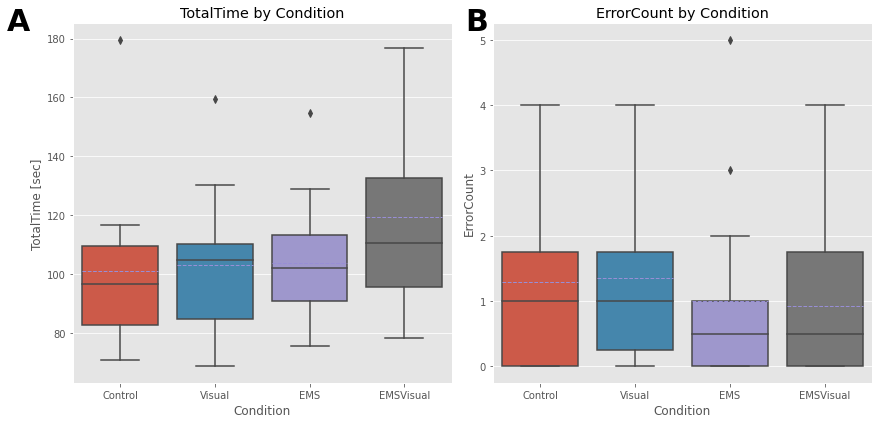

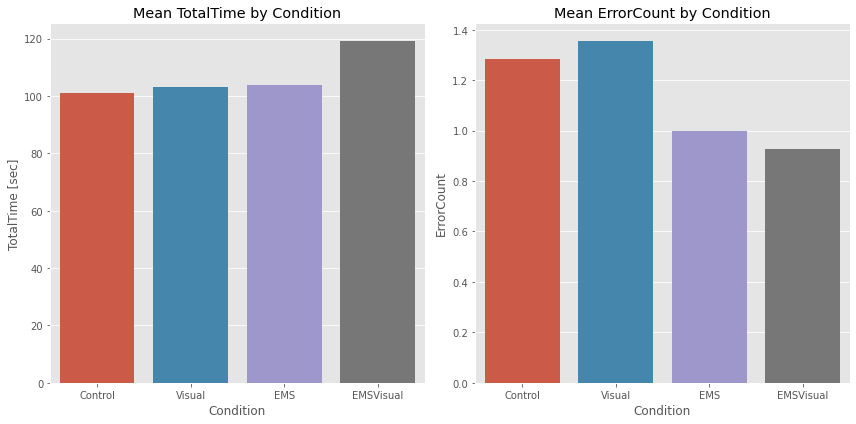

In [37]:
plt.style.use('ggplot')
# Create boxplots
fig = plt.figure(figsize=(12, 6))
fig.text(0,.92, 'A', ha='center',fontsize=30, fontweight='bold')
fig.text(0.53,.92, 'B', ha='center',fontsize=30, fontweight='bold')

plt.subplot(1, 2, 1)
sns.boxplot(x='Condition', y='TotalTime', data=final_data_df, showmeans=True, meanline=True)
plt.title('TotalTime by Condition')
plt.ylabel('TotalTime [sec]')  # Add unit to y-axis label

plt.subplot(1, 2, 2)
sns.boxplot(x='Condition', y='ErrorCount', data=final_data_df, showmeans=True, meanline=True)
plt.title('ErrorCount by Condition')

plt.tight_layout()
plt.show()

# Create bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Condition', y='TotalTime', data=final_data_df, errorbar=None)
plt.title('Mean TotalTime by Condition')
plt.ylabel('TotalTime [sec]')  # Add unit to y-axis label

plt.subplot(1, 2, 2)
sns.barplot(x='Condition', y='ErrorCount', data=final_data_df, errorbar=None)
plt.title('Mean ErrorCount by Condition')

plt.tight_layout()
plt.show()


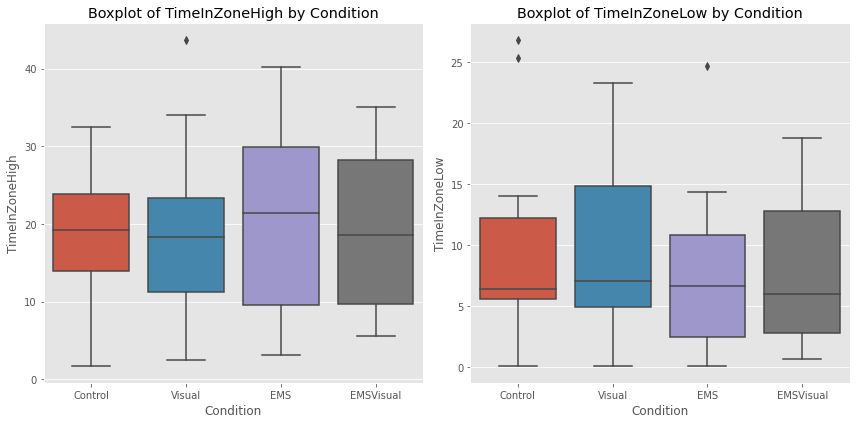

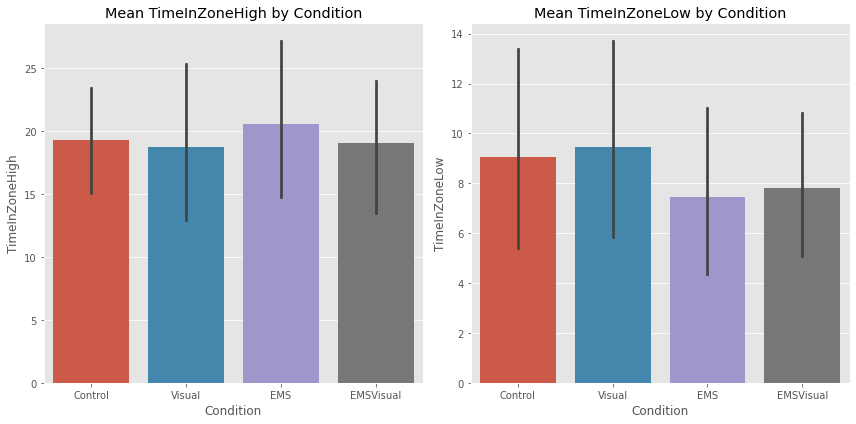

In [11]:
# Create boxplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Condition', y='TimeInZoneHigh', data=final_data_df)
plt.title('Boxplot of TimeInZoneHigh by Condition')

plt.subplot(1, 2, 2)
sns.boxplot(x='Condition', y='TimeInZoneLow', data=final_data_df)
plt.title('Boxplot of TimeInZoneLow by Condition')

plt.tight_layout()
plt.show()

# Create bar plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Condition', y='TimeInZoneHigh', data=final_data_df)
plt.title('Mean TimeInZoneHigh by Condition')

plt.subplot(1, 2, 2)
sns.barplot(x='Condition', y='TimeInZoneLow', data=final_data_df)
plt.title('Mean TimeInZoneLow by Condition')

plt.tight_layout()
plt.show()

In [12]:
# Perform Tukey HSD post-hoc test
posthoc_errorcount = pairwise_tukeyhsd(final_data_df['ErrorCount'], final_data_df['Condition'], alpha=0.05)
model_errorcount = smf.ols('ErrorCount ~ C(Condition)', data=final_data_df).fit()

print("Error Count:")
print(posthoc_errorcount)
print(model_errorcount.summary())

posthoc_totaltime = pairwise_tukeyhsd(final_data_df['Log_TotalTime'], final_data_df['Condition'], alpha=0.05)
model_totaltime = smf.ols('Log_TotalTime ~ C(Condition)', data=final_data_df).fit()

print("Total Time (log):")
print(posthoc_totaltime)
print(model_totaltime.summary())



Error Count:
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  Control       EMS  -0.2857 0.9467 -1.6699 1.0984  False
  Control EMSVisual  -0.3571 0.9024 -1.7413  1.027  False
  Control    Visual   0.0714 0.9991 -1.3127 1.4556  False
      EMS EMSVisual  -0.0714 0.9991 -1.4556 1.3127  False
      EMS    Visual   0.3571 0.9024  -1.027 1.7413  False
EMSVisual    Visual   0.4286 0.8439 -0.9556 1.8127  False
---------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:             ErrorCount   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.3252
Date:                Sun, 03 Sep 2023   Prob (F-statistic):              0.807
Time:       

# H2

In [13]:
final_data_ueq_tlx_df = pd.read_csv('./final_data_ueq_tlx.csv')


In [14]:

# Filtering based on conditions
control = final_data_ueq_tlx_df[final_data_ueq_tlx_df['Condition'] == 'Control']
ems = final_data_ueq_tlx_df[final_data_ueq_tlx_df['Condition'] == 'EMS']
visual = final_data_ueq_tlx_df[final_data_ueq_tlx_df['Condition'] == 'Visual']
ems_visual = final_data_ueq_tlx_df[final_data_ueq_tlx_df['Condition'] == 'EMSVisual']

# H2: TLX_Overall
t_stat, p_val = stats.ttest_ind(ems['TLX_Overall'], control['TLX_Overall'])
print(f'EMS vs Control - TLX_Overall: t-statistic = {t_stat}, p-value = {p_val}')

t_stat, p_val = stats.ttest_ind(ems_visual['TLX_Overall'], visual['TLX_Overall'])
print(f'EMSVisual vs Visual - TLX_Overall: t-statistic = {t_stat}, p-value = {p_val}')


t_stat, p_val = stats.ttest_ind(control['TLX_PhysicalDemand'], ems_visual['TLX_PhysicalDemand'])
print(f'Control vs EMS Visual - TLX_PhysicalDemand: t-statistic = {t_stat}, p-value = {p_val}')
t_stat, p_val = stats.ttest_ind(control['TLX_Frustration'], ems_visual['TLX_Frustration'])
print(f'Control vs EMS Visual - TLX_Frustration: t-statistic = {t_stat}, p-value = {p_val}')

EMS vs Control - TLX_Overall: t-statistic = 0.5599376351275192, p-value = 0.5803147166131173
EMSVisual vs Visual - TLX_Overall: t-statistic = 0.5292969051991664, p-value = 0.601089971751044
Control vs EMS Visual - TLX_PhysicalDemand: t-statistic = -1.5085354325510079, p-value = 0.14347436044311465
Control vs EMS Visual - TLX_Frustration: t-statistic = -2.0893227278421693, p-value = 0.04660925659073641


In [15]:

# Pivot the DataFrame to wide format for UEQ_Overall and TLX_Overall
df_wide_tlx = final_data_ueq_tlx_df.pivot(index='SubjectID', columns='Condition', values='TLX_Overall')

# Perform the repeated measures ANOVA
aov_tlx = pg.rm_anova(data=df_wide_tlx, detailed=True)

# Print the results
print("TLX_Overall")
print(aov_tlx)


TLX_Overall
   Source           SS  DF          MS         F     p-unc  p-GG-corr  \
0  Within   276.289683   3   92.096561  0.895432  0.452152   0.397093   
1   Error  4011.210317  39  102.851547       NaN       NaN        NaN   

        ng2       eps sphericity   W-spher  p-spher  
0  0.016751  0.501104      False  0.200214  0.00213  
1       NaN       NaN        NaN       NaN      NaN  


In [16]:
df = pd.read_csv('./final_data.csv')

# Calculate Pragmatic Quality and Hedonic Quality
df['Pragmatic Quality'] = df[['UEQ_behindernd_unterstützend', 'UEQ_kompliziert_einfach', 'UEQ_ineffizient_effizient', 'UEQ_verwirrend_übersichtlich']].mean(axis=1)
df['Hedonic Quality'] = df[['UEQ_langweilig_spannend', 'UEQ_uninteressant_interessant', 'UEQ_konventionell_originell', 'UEQ_herkömmlich_neuartig']].mean(axis=1)
df['Overall Quality'] = df[['UEQ_behindernd_unterstützend', 'UEQ_kompliziert_einfach', 'UEQ_ineffizient_effizient', 'UEQ_verwirrend_übersichtlich','UEQ_langweilig_spannend', 'UEQ_uninteressant_interessant', 'UEQ_konventionell_originell', 'UEQ_herkömmlich_neuartig']].mean(axis=1)

# Now we'll conduct t-tests for each of the UEQ variables and the new Pragmatic and Hedonic Quality columns
ueq_columns = ['Pragmatic Quality', 'Hedonic Quality','Overall Quality']

conditions = df['Condition'].unique()

# Conduct t-tests
for col in ueq_columns:
    print(f"\nT-tests for {col}")
    for i in range(len(conditions)):
        for j in range(i+1, len(conditions)):
            condition1 = conditions[i]
            condition2 = conditions[j]
            t_stat, p_val = stats.ttest_ind(df[df['Condition'] == condition1][col], df[df['Condition'] == condition2][col])
            print(f"{condition1} vs {condition2}: t-statistic = {t_stat}, p-value = {p_val}")


T-tests for Pragmatic Quality
Control vs Visual: t-statistic = 0.7302272012038618, p-value = 0.4713172980982553
Control vs EMS: t-statistic = 1.1575029520965177, p-value = 0.25684600886731807
Control vs EMSVisual: t-statistic = 1.906046546047756, p-value = 0.06695705273465113
Visual vs EMS: t-statistic = 0.3930429475524143, p-value = 0.6972643818392277
Visual vs EMSVisual: t-statistic = 1.059542904651426, p-value = 0.298407546840274
EMS vs EMSVisual: t-statistic = 0.6571394086069037, p-value = 0.5164569634606855

T-tests for Hedonic Quality
Control vs Visual: t-statistic = -2.0159019489137493, p-value = 0.05349720929084806
Control vs EMS: t-statistic = -3.203214997345361, p-value = 0.003377532556764124
Control vs EMSVisual: t-statistic = -3.5415469921564986, p-value = 0.001414774793483862
Visual vs EMS: t-statistic = -1.3835865565058316, p-value = 0.17741728787608496
Visual vs EMSVisual: t-statistic = -1.8295574149853915, p-value = 0.07798389750527307
EMS vs EMSVisual: t-statistic = -

In [17]:
import pandas as pd
import pingouin as pg
from numpy import mean

# Calculate Pragmatic Quality and Hedonic Quality
df['Pragmatic Quality'] = df[['UEQ_behindernd_unterstützend', 'UEQ_kompliziert_einfach', 'UEQ_ineffizient_effizient', 'UEQ_verwirrend_übersichtlich']].mean(axis=1)
df['Hedonic Quality'] = df[['UEQ_langweilig_spannend', 'UEQ_uninteressant_interessant', 'UEQ_konventionell_originell', 'UEQ_herkömmlich_neuartig']].mean(axis=1)
df['Overall Quality'] = df[['UEQ_behindernd_unterstützend', 'UEQ_kompliziert_einfach', 'UEQ_ineffizient_effizient', 'UEQ_verwirrend_übersichtlich',
                            'UEQ_langweilig_spannend', 'UEQ_uninteressant_interessant', 'UEQ_konventionell_originell', 'UEQ_herkömmlich_neuartig']].mean(axis=1)

# Create a wide-format DataFrame
conditions = df['Condition'].unique()
for col in ['Pragmatic Quality', 'Hedonic Quality', 'Overall Quality']:
    df_wide = df.pivot(index='SubjectID', columns='Condition', values=col)
    
    # Conduct rm-ANOVA
    aov = pg.rm_anova(data=df_wide, detailed=False)
    print(f"\nRM-ANOVA for {col}")
    print(aov)



RM-ANOVA for Pragmatic Quality
   Source  ddof1  ddof2         F     p-unc       ng2       eps
0  Within      3     42  1.763702  0.168779  0.057203  0.722344

RM-ANOVA for Hedonic Quality
   Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2      eps  \
0  Within      3     42  8.059701  0.000235   0.005675  0.255048  0.46987   

   sphericity   W-spher   p-spher  
0       False  0.090953  0.000013  

RM-ANOVA for Overall Quality
   Source  ddof1  ddof2        F     p-unc       ng2       eps
0  Within      3     42  1.38387  0.260891  0.040898  0.711411
